## Homework 2

Consider the following social planner's problem. There is no technical change and no population growth. The production function for final output per capita is $y=k^{\alpha}$.
\begin{equation}
\max_{c_t,k_{t+1}}\sum_{t=0}^{\infty}\beta^t\ln (c_t-\bar c),\\
\end{equation}
\begin{equation}
c_t+k_{t+1}-(1-\delta)k_t \le k_t^{\alpha},
\end{equation}
with $k_0>0$ given.$\bar c\geq 0$ is called the subsistence consumption needs. Assume that the economy starts above the subsistence requirement, i.e., $k_0^{\alpha}>\bar c$. Let $\alpha=0.3$, $\beta=0.95$, $\delta=0.05$ denotes the steady state of capital.

To begin with, I'll write down the dynamic system above.

Define the discrete-time present-value Hamiltonian:

$$
H_p\equiv \beta^t\ln (c_t-\bar c) + \lambda_{t+1}(k_t^{\alpha}-c_t-\delta k_t)
$$

Then FOCs are:

$$
\begin{aligned}
&\frac{\partial H_p}{\partial c}=0=\beta^t\frac1{c_t-\bar c}-\lambda_{t+1} \quad\dots(1)\\
&\frac{\partial H_p}{\partial k}=-(\lambda_{t+1}-\lambda_t)=\lambda_{t+1}(\alpha k_t^{\alpha-1}-\delta)\quad\dots(2)\\
&\frac{\partial H_p}{\partial \lambda}=k_{t+1}-k_t=k_t^{\alpha}-c_t-\delta k_t\quad\dots(3)
\end{aligned}
$$


From equation (1) and (2), we have Euler equation given by

$$
c_{t+1}-\bar c=\beta(1+\alpha k_{t+1}^{\alpha-1}-\delta)(c_t-\bar c)
$$

Finally, combine it with equation (3), we have the whole dynamic system:


\begin{cases}
c_{t+1}-\bar c=\beta(1+\alpha k_{t+1}^{\alpha-1}-\delta)(c_t-\bar c)\quad \dots(4)\\
k_{t+1}-k_t=k_t^{\alpha}-c_t-\delta k_t
\end{cases}

To ensure the path is indeed optimal. We have to propose TVC condition (terminal condition) :

$$
\lim_{T\rightarrow\infty}\lambda_{T+1}k_{T+1}=0=\lim_{T\rightarrow\infty}\frac{\beta^T}{c_T-\bar c}\cdot k_{T+1}
$$

a condition that will be satisfied by a path that converges to an optimal steady state.

#### 1.$\quad$ Let $\bar c=1$, $k_0=k^*/2$. Use $\underline{\textbf{ single forward shooting}}$ to solve the transitional dynamics of the resulting dynamic system. 

#### (a) Plot the time pates of consumption $c_t$ and capital $k_t$

First, I start with some standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from numba import njit, float64
from numba import jitclass
import numpy as np
from pynverse import inversefunc
import math as m
from scipy.optimize import root

I define a jitclass that stores parameters and functions that define our economy.

In [2]:
planning_data = [
    ('c̄ ', float64),    # Subsistence consumption needs
    ('β', float64),    # Discount factor
    ('δ', float64),    # Depreciation rate on capital
    ('α', float64),    # Return to capital per capita
]

In [3]:
class PlanningProblem():

    def __init__(self, c̄  =1, β=0.95, δ=0.05, α=0.3):

        self. c̄ , self.β = c̄ , β
        self.δ, self.α= δ, α

    def u(self, c):
        c̄  = self. c̄ 
 
        return log ( c - c̄  ) 

    def u_prime(self, c):
        'Derivative of utility'
        c̄  = self. c̄ 

        return 1/( c - c̄  )

    def u_prime_inv(self, c):
        'Inverse of derivative of utility'
        c̄  = self. c̄ 

        return c - c̄ 

    def f(self, k):
        'Production function'
        α= self.α

        return k ** α
    
    def f_prime(self, k):
        'derivative of production function'
        α= self.α
        
        return α* k ** (α-1)


    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α= self.α

        return (k / α) ** (1 / (α - 1))

    def next_k_c(self, k, c):
        ''''
        Given the current capital Kt and an arbitrary feasible
        consumption choice Ct, computes Kt+1 by state transition law
        and optimal Ct+1 by Euler equation.
        '''
        β, δ = self.β, self.δ
        u_prime, u_prime_inv = self.u_prime, self.u_prime_inv
        f, f_prime = self.f, self.f_prime
        c̄  = self. c̄ 

        k_next = f(k) + (1 - δ) * k - c
        c_next = c̄  + β* ( 1+ f_prime(k_next)- δ)*( c - c̄  )

        return k_next, c_next


We can construct an economy with the Python code:

In [4]:
pp = PlanningProblem()

To begin with, we calculate the steady-state capital level.

In [5]:
k_ss = pp.f_prime_inv(1 / pp.β - 1 + pp.δ)

print(f'steady state for capital is: {k_ss}')

steady state for capital is: 4.62898808913844


Given the initial condition of capital k0 and an initial guess of consumption c0, compute the whole paths of c and k using the state transition law and Euler equation for T periods:

In [6]:
def shooting(pp, c0, k0, T=150):
    
    if c0 > pp.f(k0):
        print("initial consumption is not feasible")

        return None

    # initialize vectors of c and k
    c_vec = np.empty(T+1)
    k_vec = np.empty(T+2)

    c_vec[0] = c0
    k_vec[0] = k0

    for t in range(T):
        k_vec[t+1], c_vec[t+1] = pp.next_k_c(k_vec[t], c_vec[t])

    k_vec[T+1] = pp.f(k_vec[T]) + (1 - pp.δ) * k_vec[T] - c_vec[T]

    return c_vec, k_vec

Since in this case, we consider k0 as given and arbitrarily set an intial consumption level c0. But, on the other hand, we have to ensure that $k_t$ converges to the steady-state capital level.

Intuitively, the "shape" of the routes are determined, but there are still many plenty of others. We have to pick the "best" (i.e., satisfying the terminal condition) among them.

Then the bisection method is used to ensure that the terminal solution ( i.e., $k_t$ converges to the steady-state capital level ) calculated by the approach above is indeed statisfied. 

Intuitively, the direction of this shooting method is then corrected.

In [7]:
def bisection(pp, c0, k0, T=150, tol=1e-4, max_iter=1000, k_ter=k_ss, verbose=True):

    # initial boundaries for guess c0
    c0_upper = pp.f(k0)
    c0_lower = 1

    i = 0
    
    while True:
        c_vec, k_vec = shooting(pp, c0, k0, T)
        error = k_vec[-1] - k_ter

        # check if the terminal condition is satisfied
        if np.abs(error) < tol:
            if verbose:
                print('Converged successfully on iteration ', i+1)
            return c_vec, k_vec

        i += 1
        if i == max_iter:
            if verbose:
                print('Convergence failed.')
            return c_vec, k_vec

        # if iteration continues, updates boundaries and guess of c0
        if error > 0:
            c0_lower = c0
        else:
            c0_upper = c0

        c0 = (c0_lower + c0_upper) / 2

Finally, we can plot the optimal paths of consumption, capital.

In [8]:
def plot_paths(pp, c0, k0, T, k_ter=k_ss, axs=None):

    if axs is None:
        fix, axs = plt.subplots(1, 2, figsize=(16, 4))
    ylabels = ['$c_t$', '$k_t$']
    titles = ['Consumption', 'Capital']

    c_paths = []
    k_paths = []
    
    c_vec, k_vec = bisection(pp, c0, k0, T)
    c_paths.append(c_vec)
    k_paths.append(k_vec)
    
    paths = [c_vec, k_vec]
    
    for i in range(2):
        axs[i].plot(paths[i])
        axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

    # Plot steady state value of capital
    axs[1].axhline(k_ss, c='k', ls='--', lw=1)
    axs[1].axvline(T+1, c='k', ls='--', lw=1)
    axs[1].scatter(T+1, paths[1][-1], s=80)

    return c_paths, k_paths

Converged successfully on iteration  35


C:\Users\matebookD14\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\matebookD14\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


([array([1.11045318, 1.11686742, 1.12333615, 1.12983948, 1.13635815,
         1.14287374, 1.14936877, 1.15582681, 1.16223259, 1.16857203,
         1.17483226, 1.18100166, 1.18706981, 1.1930275 , 1.19886668,
         1.20458042, 1.21016284, 1.21560909, 1.22091523, 1.22607821,
         1.2310958 , 1.2359665 , 1.24068949, 1.24526458, 1.24969213,
         1.253973  , 1.25810849, 1.2621003 , 1.26595046, 1.26966132,
         1.27323546, 1.27667569, 1.27998501, 1.28316656, 1.28622359,
         1.28915946, 1.29197759, 1.29468144, 1.29727452, 1.29976034,
         1.30214238, 1.30442413, 1.30660905, 1.30870054, 1.31070196,
         1.31261662, 1.31444776, 1.31619855, 1.31787208, 1.31947139,
         1.3209994 , 1.32245897, 1.32385289, 1.32518385, 1.32645445,
         1.32766722, 1.32882459, 1.32992891, 1.33098247, 1.33198745,
         1.33294595, 1.33386002, 1.33473159, 1.33556256, 1.33635472,
         1.33710981, 1.33782949, 1.33851535, 1.33916893, 1.33979169,
         1.34038504, 1.34095032, 1

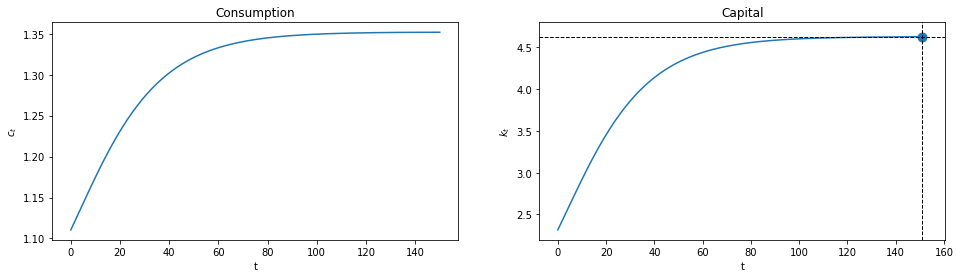

In [9]:
plot_paths(pp, 0.9, k_ss/2, 150)

#### (b) Plot the steady state curve of $\dot c=0$, and $\dot k=0$ in a (k,c) locus

When $\dot k=0$, from equation (3), we have

$$
c=k^{\alpha}-\delta k
$$

When $\dot c=0$, from equation (4), we have

$$
\beta(1+\alpha k^{\alpha-1}-\delta)=1
$$

Thus, we can plot the steady state curve with the following codes:

<function matplotlib.pyplot.show(*args, **kw)>

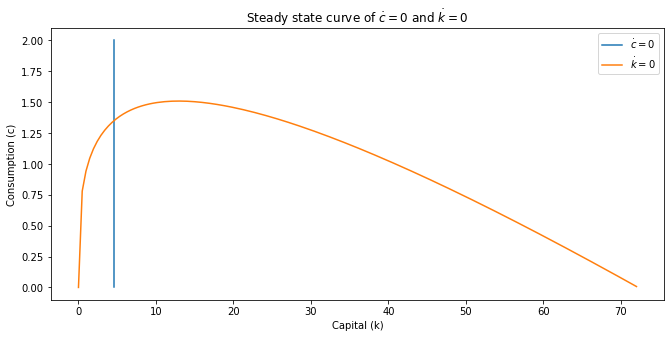

In [10]:
fig, ax = plt.subplots()

c = np.linspace(0,2,150)
k = np.linspace(0,72,150)

c_s=k**pp.α-pp.δ*k
k_s = np.linspace(k_ss,k_ss,150)


ax.plot(k_s, c, label='$\dot c = 0$')
ax.plot(k, c_s, label='$\dot k = 0 $')

ax.set_xlabel('Capital (k)')
ax.set_ylabel('Consumption (c)')
ax.set_title('Steady state curve of $\dot c=0$ and $\dot k=0$')
ax.legend()

plt.show

#### (c) Plot the policy function $c=f(k)$ (i.e., the stable saddle path)

The policy funtion is the stable saddle path leading towards the steady state level of capital and consumption.

As we have already calculated the optimal paths of c and k respectively above, the corresponding policy function is shown below:

C:\Users\matebookD14\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\matebookD14\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


Converged successfully on iteration  38


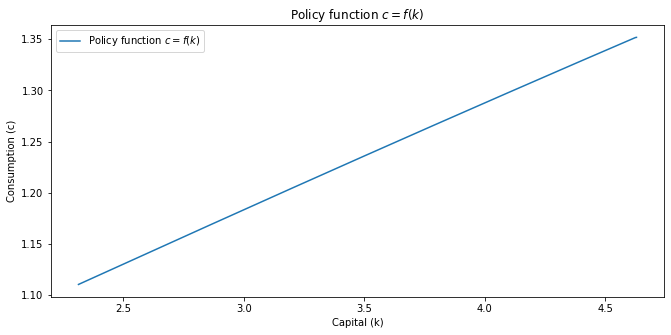

In [11]:
c_vec, k_vec = bisection(pp, 1, k_ss/2, 150)
k_vec = k_vec[:-1]

fig, ax = plt.subplots()

ax.plot(k_vec, c_vec, label = 'Policy function $c=f(k)$')

ax.set_xlabel('Capital (k)')
ax.set_ylabel('Consumption (c)')
ax.set_title('Policy function $c=f(k)$')
ax.legend()

plt.show()

#### (d) Plot the time path of the saving rate (investment/output)

First, we can calculate the steady-state saving rate by

In [12]:
s_ss = pp.δ * k_ss / pp.f(k_ss)

Moreover, given optimal paths of c and k, we can compute the path of saving rate.

In [13]:
def saving_rate(pp, c_path, k_path):
    production = pp.f(k_path[:-1])

    return (production - c_path) / production

Then, a function is defined below to plot the saving rate in a figure.

In [14]:
def plot_saving_rate(pp, c0, k0, T, k_ter=0, k_ss=None, s_ss=None):

    fix, axs = plt.subplots(1, 3, figsize=(16, 4))

    c_paths, k_paths = plot_paths(pp, c0, k0, T, k_ter=k_ter, axs=axs.flatten())


    s_path = saving_rate(pp, c_paths[0], k_paths[0])
    axs[2].plot(s_path)

    axs[2].set(xlabel='t', ylabel='$s_t$', title='Saving rate')

    if s_ss is not None:
        axs[2].hlines(s_ss, 0, np.max(T), linestyle='--')

C:\Users\matebookD14\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\matebookD14\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


Converged successfully on iteration  35


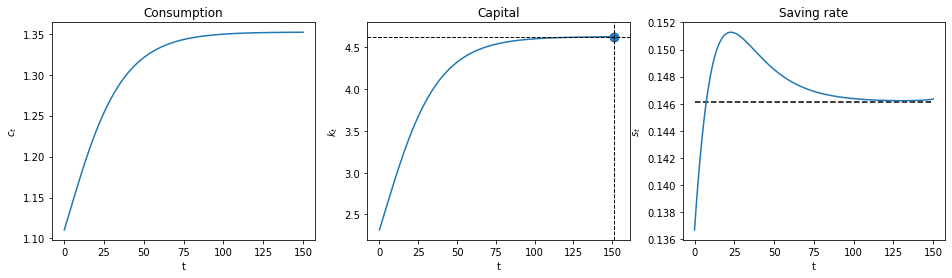

In [15]:
plot_saving_rate(pp, 0.9, k_ss/2, 150, k_ter=k_ss, s_ss=s_ss)

#### (e) Plot the time path of per capita income in log scale

As we have calculated the path of capital above, we can now calculate the corresponding time path of per capita income in log scale with following codes:

C:\Users\matebookD14\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\matebookD14\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


Converged successfully on iteration  38


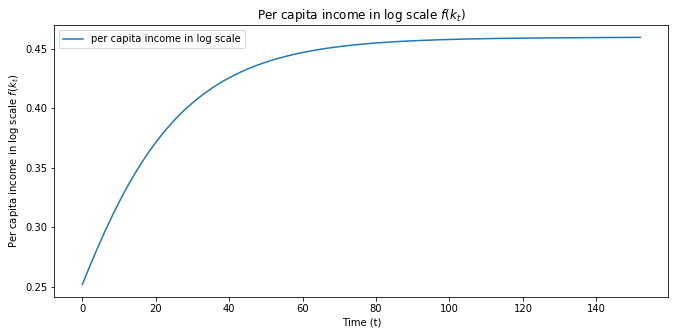

In [16]:
c_vec, k_vec = bisection(pp, 1, k_ss/2, 150)
y_path= pp.f(k_vec)

fig, ax = plt.subplots()

t = np.linspace(0,152,152)
ax.plot(t, np.log(y_path), label = 'per capita income in log scale')

ax.set_xlabel('Time (t)')
ax.set_ylabel('Per capita income in log scale $f(k_t)$')
ax.set_title('Per capita income in log scale $f(k_t)$')
ax.legend()

plt.show()

#### 2.$\quad$ Let $\bar c=0.5$, $k_0=k^*/2$. Use $\underline{\textbf{ backward shooting}}$ to solve the transitional dynamics of the resulting dynamic system. 

The basic logic behind the backward shooting method is as follows:

Start from the dynamic system of this problem:

\begin{cases}
c_{t+1}-\bar c=\beta(1+\alpha k_{t+1}^{\alpha-1}-\delta)(c_t-\bar c)\quad \dots(4)\\
k_{t+1}-k_t=k_t^{\alpha}-c_t-\delta k_t\quad \dots(5)
\end{cases}

1. Given the terminal capital level, say, $k_{t+1}=k\_ss-\epsilon$ (where $\epsilon$ is sufficiently small), arbitrarily set the level of $k_t$.

2. From equation (5) above, we can calculate the consumption level of time t ( namely, $c_t$ )

3. Combine with equation (4), consumption level of time t-1 ( $c_{t-1}$ ) can be calculated.

4. Put the results back to equation (5), we get $k_{t-1}$; and put the results back to equation (4) again to abtain $c_{t-2}$

5. Iterate the process above, until we get initial capital $k_0$, check with the given $k_0$. If they have a large gap, choose another $k_t$ and repeat the process again.

#### (a) Plot the time paths of consumption $c_t$ and capital $k_t$

In order to simplify the procedures below, I first calculate the inverse function of 
$$
g(k)=k^{\alpha}+(1-\delta)k
$$

In [17]:
def g_inv(pp, k, c_last):
    g = (lambda k: k**pp.α+(1-pp.δ)*k)
    g_inv = inversefunc(g,domain=[0,k_ss])
    
    return float(g_inv(k+c_last))

Then we can always make use of equation (4) and (5) to calculate $k_{t-1}$ and $c_{t-1}$ if we know $k_{t}$ and $c_{t}$

In [18]:
c̄=0.5
def last_c_k(pp, c, k):
    c_last = (c - c̄)/(pp.β*(1+pp.α*k**(pp.α-1)-pp.δ)) + c̄ # use equation (4) to calculate c of last period
    
    k_last = g_inv(pp, k, c_last) # use equation (5) to calculate k of last period
    
    return c_last, k_last

In [19]:
def shooting_back(pp, kt, k_ter, k0, T):
    if kt > k_ss: 
        print("guess of kt is not feasible")
        
        return None
    
    # initial vectors of c and k
    c_vec = np.linspace(0,0,T+1)
    k_vec = np.linspace(0,0,T+2)
    
    k_vec[-1] = k_ter # k_{T+1} given
    k_vec[-2] = kt  # guess k_{T}
    
    c_vec[-1] = k_vec[-2]**pp.α+(1-pp.δ)*k_vec[-2]-k_vec[-1]  # use equation (5) to calculate the terminal consumption level
    
    for t in range(T, 0, -1):
        c_vec[t-1], k_vec[t-1] = last_c_k(pp, c_vec[t], k_vec[t])
            
    return c_vec, k_vec

Then the method of shooting backwards can defined and calculated

In [20]:
def bisection_back(pp, kt, k_ter, k0, tol=1e-4, max_iter=1000, verbose=True):
    
    ## initial boundaries for guessing kt
    kt_upper = k_ss
    kt_lower = 0
    
    i=0
    
    while True:
        c_vec, k_vec = shooting_back(pp, kt, k_ter, k0, 150)
        error = k_vec[0] - k0
        
        # check if the initial k0  condition is satisfied
        if np.abs(error) < tol:
            if verbose:
                print("Converged successfully on iteration", i+1)
            return c_vec, k_vec
        
        i+=1
    
        if i==max_iter:
            if verbose:
                print("Convergence failed.")
            return c_vec, k_vec
    
        # if iteration continues, updates boundaries and guess of kt
        if error > 0:
            kt_upper = kt
        else:
            kt_lower = kt
        
        kt = (kt_upper+kt_lower)/2

Finally, we can plot the optimal paths of consumption and capital

Converged successfully on iteration 31


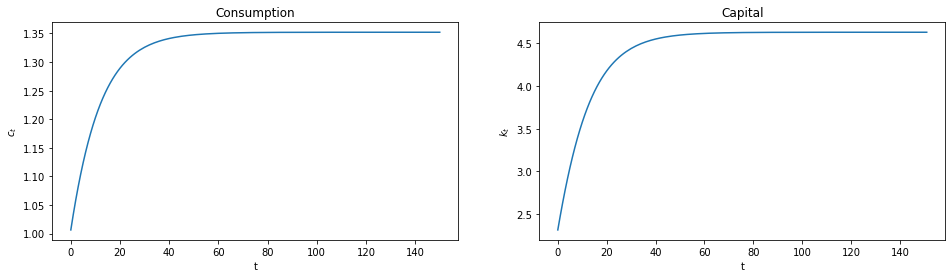

In [21]:
fix, axs = plt.subplots(1, 2, figsize=(16,4))
ylabels = ['$c_t$', '$k_t$']
titles = ['Consumption', 'Capital']

# Final paths of consumption and capital:
c_vec_back, k_vec_back = bisection_back(pp, k_ss-0.1, k_ss, k_ss/2)
    
paths = [c_vec_back, k_vec_back]
    
for i in range(2):
        axs[i].plot(paths[i])
        axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])
    
plt.show()

#### (b) Plot the steady state curve of $\dot c=0$, and $\dot k=0$ in a (k,c) locus

Note that the steady state curves remain the same, even though the subsistence level of $\bar c$ changes

<function matplotlib.pyplot.show(*args, **kw)>

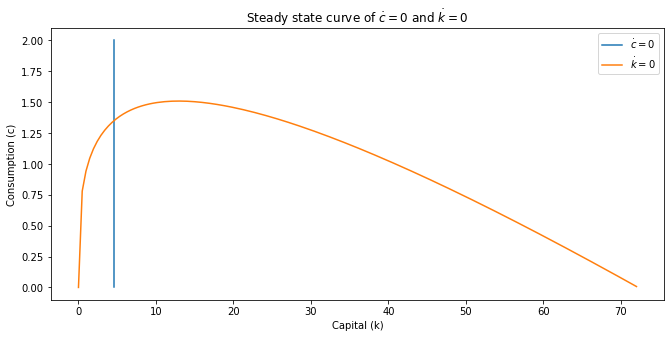

In [22]:
fig, ax = plt.subplots()

c = np.linspace(0,2,150)
k = np.linspace(0,72,150)

c_s=k**pp.α-pp.δ*k
k_s = np.linspace(k_ss,k_ss,150)


ax.plot(k_s, c, label='$\dot c = 0$')
ax.plot(k, c_s, label='$\dot k = 0 $')

ax.set_xlabel('Capital (k)')
ax.set_ylabel('Consumption (c)')
ax.set_title('Steady state curve of $\dot c=0$ and $\dot k=0$')
ax.legend()

plt.show

#### (c) Plot the policy function $c=f(k)$ (i.e., the stable saddle path)

Converged successfully on iteration 31


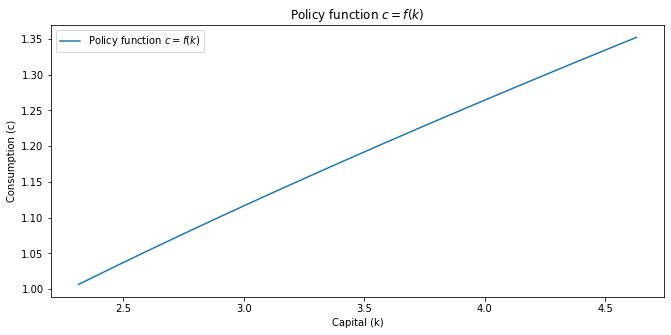

In [23]:
c_vec_back, k_vec_back = bisection_back(pp, k_ss-0.1, k_ss, k_ss/2)
k_vec_back = k_vec_back[:-1]

fig, ax = plt.subplots()

ax.plot(k_vec_back, c_vec_back, label = 'Policy function $c=f(k)$')

ax.set_xlabel('Capital (k)')
ax.set_ylabel('Consumption (c)')
ax.set_title('Policy function $c=f(k)$')
ax.legend()

plt.show()

#### (d) Plot the time path of the saving rate (investment/output)

The saving rate is defined in the following way:

In [24]:
def saving_rate_back(pp, c_vec, k_path):
    output = pp.f(k_path)
    
    return (output - c_vec)/output

Then, given the optimal paths of c and k, we can then calculate and plot the paths of saving rate

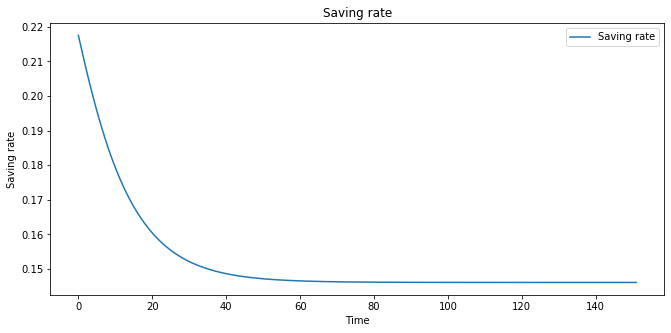

In [25]:
fix, ax = plt.subplots()

t = np.linspace(0,151,151)
saving_rate_back = saving_rate_back(pp, c_vec_back, k_vec_back)

ax.plot(t, saving_rate_back, label = 'Saving rate')

ax.set_xlabel('Time')
ax.set_ylabel('Saving rate')
ax.set_title('Saving rate')
ax.legend()

plt.show()

#### (e) Plot the time path of per capita income in log scale

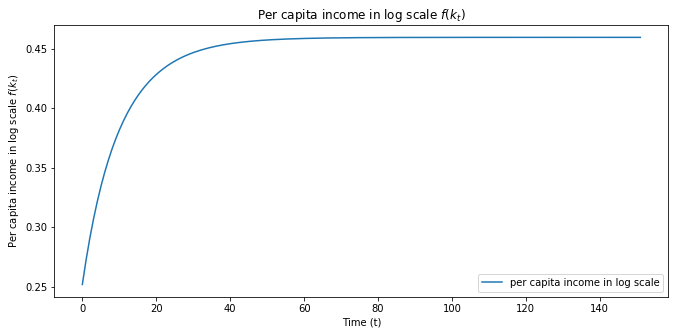

In [26]:
fig, ax = plt.subplots()
y_path_back = pp.f(k_vec_back)

t = np.linspace(0,151,151)
ax.plot(t, np.log(y_path_back), label = 'per capita income in log scale')

ax.set_xlabel('Time (t)')
ax.set_ylabel('Per capita income in log scale $f(k_t)$')
ax.set_title('Per capita income in log scale $f(k_t)$')
ax.legend()

plt.show()

#### 2.$\quad$ Let $\bar c=0$, $k_0=k^*/2$. Use $\underline{\textbf{ multiple forward shooting}}$ to solve the transitional dynamics of the resulting dynamic system. 

From the dynamic system above, we can calculate the following second-order difference equation:

$$
k_{t+2}-k_{t+1}^{\alpha}-(1-\delta)k_{t+1}+\bar c+\beta(1+\alpha k_{t+1}^{\alpha-1}-\delta)[-k_{t+1}+k_t^{\alpha}+(1-\delta)k_t-\bar c]=0, \quad \forall t=0,1,\dots,T-1
$$

Thus, given $k_0=k^*/2$ and $k_{T+1}=k^*$, we can obtain the whole paths of capital level, $\{k_t\}_{t=0}^{T+1}$, with T equations above

That is to say, we need to find $k_1$, $k_2$,$\dots k_T$ simultaniously by solving the following nonlinear equation system:

\begin{cases}
k_{2}-k_{1}^{\alpha}-(1-\delta)k_{1}+\bar c+\beta(1+\alpha k_{1}^{\alpha-1}-\delta)[-k_{1}+k_0^{\alpha}+(1-\delta)k_0-\bar c]=0,\\
k_{3}-k_{2}^{\alpha}-(1-\delta)k_{2}+\bar c+\beta(1+\alpha k_{2}^{\alpha-1}-\delta)[-k_{2}+k_{1}^{\alpha}+(1-\delta)k_{1}-\bar c]=0,\\
\dots\\
k_{T}-k_{T-1}^{\alpha}-(1-\delta)k_{T-1}+\bar c+\beta(1+\alpha k_{T-1}^{\alpha-1}-\delta)[-k_{T-1}+k_{T-2}^{\alpha}+(1-\delta)k_{T-2}-\bar c]=0,\\
k^{*}-k_{T}^{\alpha}-(1-\delta)k_{T}+\bar c+\beta(1+\alpha k_{T}^{\alpha-1}-\delta)[-k_{T}+k_{T-1}^{\alpha}+(1-\delta)k_{T-1}-\bar c]=0,\\
\end{cases}

where $k_0$ and $k^*$ are given.

#### (a) Plot the time pates of consumption $c_t$ and capital $k_t$

To begin with, I define the nonlinear equation system above:

In [27]:
# Define the nonlinear equation system
c̄ = 0
α= 0.3
β=0.95
δ=0.05
# Note: the reason that I  use δ, α,etc,  instead of  pp.δ,pp.α,etc, is that I find "class" cannot be used in the root() function below

def f_sys(k, T, k0=k_ss/2):
    sys = []
    
    sys.append(k[1]-k[0]**α-(1-δ)*k[0]+c̄+β*(α*k[0]**(α-1)+1-δ)*(-k[0]+k0**α+(1-δ)*k0-c̄))
    
    for t in range(T-2):
        sys.append(k[t+2]-k[t+1]**α-(1-δ)*k[t+1]+c̄+β*(α*k[t+1]**(α-1)+1-δ)*(-k[t+1]+k[t]**α+(1-δ)*k[t]-c̄))
    
    sys.append(k_ss-k[T-1]**α-(1-δ)*k[T-1]+c̄+β*(α*k[T-1]**(α-1)+1-δ)*(-k[T-1]+k[T-2]**α+(1-δ)*k[T-2]-c̄))
    
    return sys

Then, I use root() to solve the nonlinear equation system above ( given $k_0$ and $k_{T+1}$ )

In [28]:
def shooting_multiple(k0, T):
    x0 = [1]*150     # initial guess of the solution path
    
    k_vec = [k0]+list(root(f_sys, x0, T).x)+[k_ss]  # dimetnsion of k_vec = 1+150+1=152
    
    # And the path of consumption (c) is calculated using equation (5) above.
    c_vec = []
    
    for t in range(T+1):
        c_vec.append(-k_vec[t+1]+k_vec[t]**α+(1-δ)*k_vec[t])
        
    return k_vec, c_vec

Finally, the optimal paths of consumption and capital can be plotted as follows:

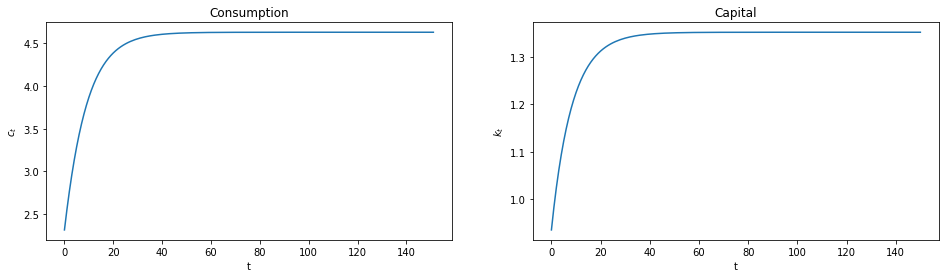

In [29]:
fix, axs = plt.subplots(1, 2, figsize=(16,4))
ylabels = ['$c_t$', '$k_t$']
titles = ['Consumption', 'Capital']

# Final paths of consumption and capital:
c_vec_multiple, k_vec_multiple = shooting_multiple(k0=k_ss/2, T=150)
    
paths_multiple = [c_vec_multiple, k_vec_multiple]
    
for i in range(2):
        axs[i].plot(paths_multiple[i])
        axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])
    
plt.show()

#### (b) Plot the steady state curve of $\dot c=0$, and $\dot k=0$ in a (k,c) locus

Note that the steady state curves remain the same, even though the subsistence level of $\bar c$ changes

<function matplotlib.pyplot.show(*args, **kw)>

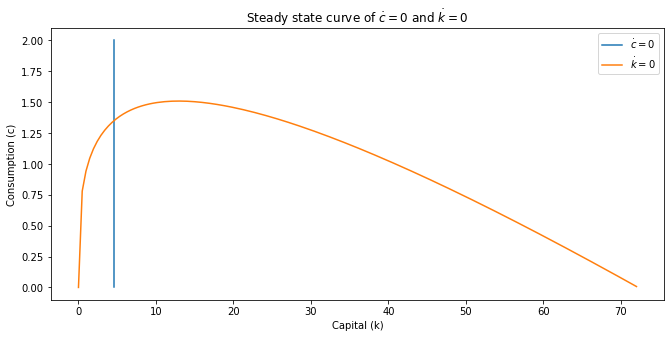

In [30]:
fig, ax = plt.subplots()

c = np.linspace(0,2,150)
k = np.linspace(0,72,150)

c_s=k**pp.α-pp.δ*k
k_s = np.linspace(k_ss,k_ss,150)


ax.plot(k_s, c, label='$\dot c = 0$')
ax.plot(k, c_s, label='$\dot k = 0 $')

ax.set_xlabel('Capital (k)')
ax.set_ylabel('Consumption (c)')
ax.set_title('Steady state curve of $\dot c=0$ and $\dot k=0$')
ax.legend()

plt.show

#### (c) Plot the policy function $c=f(k)$ (i.e., the stable saddle path)

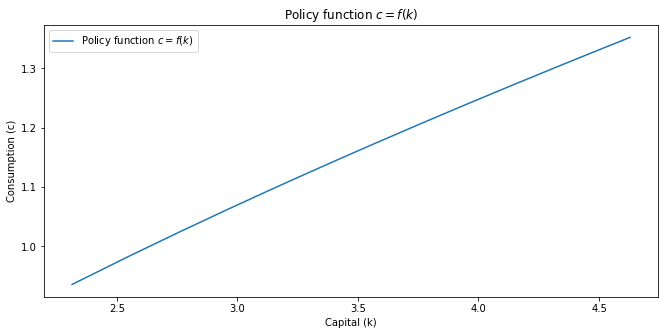

In [31]:
k_vec_multiple, c_vec_multiple = shooting_multiple(k0=k_ss/2, T=150)
k_vec_multiple = k_vec_multiple[:-1]

fig, ax = plt.subplots()

ax.plot(k_vec_multiple, c_vec_multiple, label = 'Policy function $c=f(k)$')

ax.set_xlabel('Capital (k)')
ax.set_ylabel('Consumption (c)')
ax.set_title('Policy function $c=f(k)$')
ax.legend()

plt.show()

#### (d) Plot the time path of the saving rate (investment/output)

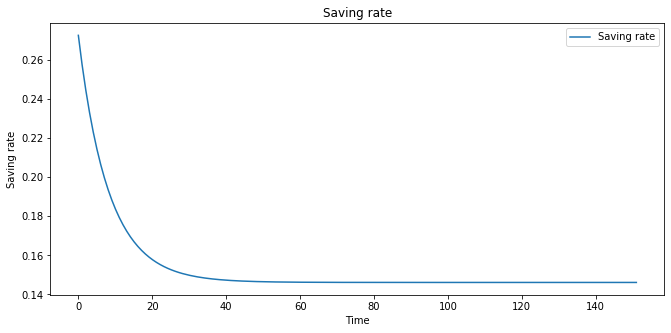

In [32]:
saving_rate_multiple = [(k_vec_multiple[i]**α-c_vec_multiple[i])/k_vec_multiple[i]**α for i in range(151)]

fix, ax = plt.subplots()

t = np.linspace(0,151,151)

ax.plot(t, saving_rate_multiple, label = 'Saving rate')

ax.set_xlabel('Time')
ax.set_ylabel('Saving rate')
ax.set_title('Saving rate')
ax.legend()

plt.show()


#### (e) Plot the time path of per capita income in log scale

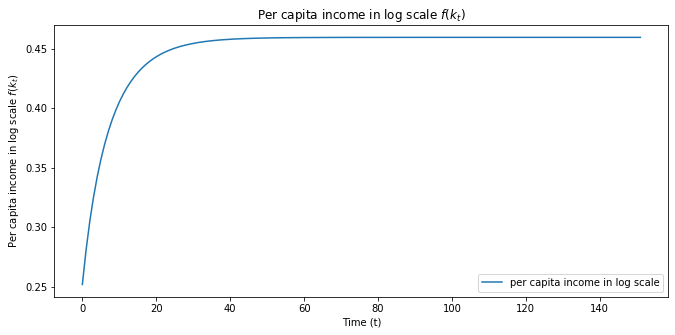

In [33]:
fig, ax = plt.subplots()
y_path_multiple = [k_vec_multiple[i]**α for i in range(151)]

t = np.linspace(0,151,151)
ax.plot(t, np.log(y_path_multiple), label = 'per capita income in log scale')

ax.set_xlabel('Time (t)')
ax.set_ylabel('Per capita income in log scale $f(k_t)$')
ax.set_title('Per capita income in log scale $f(k_t)$')
ax.legend()

plt.show()